# Phase2

# Connection

In [15]:

import pprint as pp
import requests

host = 'api.novasearch.org'
port = 443

user = 'user02' # Add your user name here.
password = 'marco.2025+' # Add your user password here. For testing only. Don't store credentials in code. 
index_name = user

In [5]:
import urllib3
urllib3.disable_warnings()  # Suppress self-signed cert warnings

from requests.auth import HTTPBasicAuth
import requests
import pprint as pp

host = 'localhost'
port = 9200
user = 'admin'
password = 'MyStr0ng@Pass'
index_name = user

url = f"https://{host}:{port}"

try:
    res = requests.get(url, auth=HTTPBasicAuth(user, password), verify=False)
    pp.pprint(res.json())
except requests.exceptions.RequestException as e:
    print("Request failed:", e)


{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'Dz8zYNxKRRW7_XlgD9t0_Q',
 'name': 'bc179bd207bf',
 'tagline': 'The OpenSearch Project: https://opensearch.org/',
 'version': {'build_date': '2025-02-27T01:16:47.726162386Z',
             'build_hash': '2e4741fb45d1b150aaeeadf66d41445b23ff5982',
             'build_snapshot': False,
             'build_type': 'tar',
             'distribution': 'opensearch',
             'lucene_version': '9.12.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.10.0',
             'number': '2.19.1'}}


# Frame Extraction

In [21]:
import pandas as pd
from pathlib import Path
import json
import yt_dlp
import av # For frame extraction
import os
import time
import math # For ceiling function if needed for frame counts

# --- Provided load_captions function (remains the same) ---
def load_captions(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    result = []
    for vid_key, meta_info in data.items():
        if isinstance(meta_info, dict) and 'timestamps' in meta_info and 'sentences' in meta_info:
            for (start, end), sentence in zip(meta_info['timestamps'], meta_info['sentences']):
                result.append({
                    "video_id": vid_key,
                    "duration": meta_info.get("duration", 0),
                    "start": start,
                    "end": end,
                    "caption": sentence,
                    "video_url": f"https://www.youtube.com/watch?v={vid_key[2:]}" if vid_key.startswith("v_") else f"https://www.youtube.com/watch?v={vid_key}"
                })
        # else:
            # print(f"Warning: Skipping entry {vid_key} in load_captions due to unexpected structure or missing keys.")
    return result

# --- Setup ---
repo_root = Path().resolve()
json_path = repo_root / "captions" / "train.json"
OUTPUT_DIR = "extracted_frames"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- CONFIGURATION for frame extraction ---
FRAME_EXTRACTION_INTERVAL_SECONDS = 2.0

if not json_path.exists():
    print(f"Error: JSON file not found at {json_path}")
    exit()
# print(f"Loading captions from: {json_path}") # Reduced verbosity
data = load_captions(str(json_path))
if not data:
    print("No data loaded from captions file. Exiting.")
    exit()
df = pd.DataFrame(data)
if df.empty:
    print("DataFrame is empty after loading captions. Exiting.")
    exit()

# --- Filtering logic ---
contains_car = df[df['caption'].str.contains(r'\bcar\b', case=False, na=False)]
car_video_ids = set(contains_car['video_id'])
caption_counts = df['video_id'].value_counts()
videos_with_8plus = set(caption_counts[caption_counts > 8].index)
valid_video_ids = list(car_video_ids & videos_with_8plus)

# print(f"Found {len(valid_video_ids)} potentially valid video IDs based on caption criteria.") # Reduced verbosity

video_id_to_url_map = {}
if not df.empty and 'video_id' in df.columns and 'video_url' in df.columns:
    temp_df_for_urls = df[df['video_id'].isin(valid_video_ids)][['video_id', 'video_url']].drop_duplicates()
    video_id_to_url_map = pd.Series(temp_df_for_urls.video_url.values, index=temp_df_for_urls.video_id).to_dict()
else:
    print("DataFrame is missing 'video_id' or 'video_url' columns. Cannot proceed with URL mapping.")
    exit()

# --- Download videos and extract frames ---
TARGET_SUCCESSFUL_VIDEOS = 10
successfully_processed_count = 0
attempted_video_index = 0
successfully_downloaded_ids_and_framesinfo = []

print(f"\nStarting video processing (aiming for {TARGET_SUCCESSFUL_VIDEOS} successful videos)...")

while successfully_processed_count < TARGET_SUCCESSFUL_VIDEOS and attempted_video_index < len(valid_video_ids):
    video_id = valid_video_ids[attempted_video_index]
    attempted_video_index += 1

    url = video_id_to_url_map.get(video_id)
    if not url:
        print(f"Video ID {video_id}: Could not find URL. Skipping.")
        continue

    # print(f"\nAttempting to process video {attempted_video_index}/{len(valid_video_ids)} (target {successfully_processed_count+1}/{TARGET_SUCCESSFUL_VIDEOS}): {video_id}") # Reduced verbosity
    
    download_filename_template = f"{video_id}.mp4"
    temp_download_dir = os.path.join(OUTPUT_DIR, "temp_videos")
    os.makedirs(temp_download_dir, exist_ok=True)
    local_video_path_template = os.path.join(temp_download_dir, download_filename_template)
    
    actual_downloaded_video_path = None

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': local_video_path_template,
        'quiet': True, # Suppress yt-dlp console output
        'noplaylist': True,
        'socket_timeout': 30,
        'logtostderr': False, # Don't log to stderr when quiet
        'no_warnings': True, # Suppress warnings when quiet
    }

    try:
        # print(f"Processing video: {video_id}...") # Reduced verbosity, combined below
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(url, download=True)
            actual_downloaded_video_path = ydl.prepare_filename(info_dict)

            if not os.path.exists(actual_downloaded_video_path):
                 if os.path.exists(local_video_path_template):
                      actual_downloaded_video_path = local_video_path_template
                 else:
                      print(f"Video ID {video_id}: Download failed or file not found.")
                      continue
        
        # print(f"Downloaded {video_id} to {actual_downloaded_video_path}") # Reduced verbosity

        # print(f"Extracting frames for {video_id}...") # Reduced verbosity
        video_frames_output_dir = os.path.join(OUTPUT_DIR, video_id)
        os.makedirs(video_frames_output_dir, exist_ok=True)
        
        frames_extracted_count = 0
        with av.open(actual_downloaded_video_path) as container:
            stream = container.streams.video[0]
            fps = stream.average_rate
            if not fps or float(fps) == 0: fps = stream.guessed_rate
            if not fps or float(fps) == 0: fps = stream.r_frame_rate
            if not fps or float(fps) == 0:
                print(f"Video ID {video_id}: Could not determine FPS. Skipping frame extraction.")
                continue
            fps = float(fps)
            if fps <= 0:
                print(f"Video ID {video_id}: Invalid FPS ({fps}). Skipping frame extraction.")
                continue

            frames_to_skip_per_interval = int(round(fps * FRAME_EXTRACTION_INTERVAL_SECONDS))
            if frames_to_skip_per_interval <= 0: frames_to_skip_per_interval = 1
            
            # print(f"  Video FPS: {fps:.2f}, Extracting 1 frame every {frames_to_skip_per_interval} frames.") # Reduced verbosity

            frame_index_in_video = 0
            next_extraction_frame_index = 0

            for frame_obj in container.decode(stream):
                if frame_index_in_video >= next_extraction_frame_index:
                    timestamp_seconds = frame_obj.time
                    timestamp_str = f"{timestamp_seconds:.2f}".replace('.', '_')
                    out_frame_path = os.path.join(video_frames_output_dir, f"{video_id}_ts_{timestamp_str}_frame_{frames_extracted_count:04d}.jpg")
                    frame_obj.to_image().save(out_frame_path, quality=80)
                    frames_extracted_count += 1
                    next_extraction_frame_index += frames_to_skip_per_interval
                frame_index_in_video += 1
        
        if frames_extracted_count > 0:
            print(f"Video ID {video_id}: Success - {frames_extracted_count} frames extracted.")
            successfully_processed_count += 1
            successfully_downloaded_ids_and_framesinfo.append({'video_id': video_id, 'num_frames_extracted': frames_extracted_count, 'frames_path': video_frames_output_dir})
        else:
            print(f"Video ID {video_id}: Downloaded but no frames extracted (check FPS/length).")

    except yt_dlp.utils.DownloadError as e_dl:
        error_msg = str(e_dl).lower()
        # Simplified error reporting
        if "video unavailable" in error_msg: print(f"Video ID {video_id}: Failed - Video unavailable.")
        elif "private video" in error_msg: print(f"Video ID {video_id}: Failed - Private video.")
        elif "login required" in error_msg or "account action required" in error_msg: print(f"Video ID {video_id}: Failed - Login/account action required.")
        elif "http error 400" in error_msg: print(f"Video ID {video_id}: Failed - HTTP Error 400.")
        elif "http error 403" in error_msg: print(f"Video ID {video_id}: Failed - HTTP Error 403 (Forbidden).")
        elif "socket timeout" in error_msg: print(f"Video ID {video_id}: Failed - Socket timeout.")
        else: print(f"Video ID {video_id}: Failed - yt-dlp download error: {e_dl}")
    except Exception as e:
        print(f"Video ID {video_id}: Failed - Unexpected error: {e}")
        # import traceback # Optionally keep for debugging
        # traceback.print_exc()
    finally:
        if actual_downloaded_video_path and os.path.exists(actual_downloaded_video_path):
            try:
                # print(f"Cleaning up video file: {actual_downloaded_video_path}") # Reduced verbosity
                os.remove(actual_downloaded_video_path)
            except Exception as e_remove:
                print(f"Warning: Failed to remove video file {actual_downloaded_video_path}: {e_remove}")
    
    # time.sleep(0.5) # Keep if desired for rate limiting

print(f"\nFinished processing loop.")
print(f"{successfully_processed_count} of {attempted_video_index} attempted videos had frames successfully extracted.")
if successfully_processed_count < TARGET_SUCCESSFUL_VIDEOS and attempted_video_index == len(valid_video_ids):
    print(f"Target of {TARGET_SUCCESSFUL_VIDEOS} successful videos not reached. All {len(valid_video_ids)} potential videos processed.")
elif successfully_processed_count < TARGET_SUCCESSFUL_VIDEOS:
     print(f"Target of {TARGET_SUCCESSFUL_VIDEOS} successful videos not reached.")


if successfully_downloaded_ids_and_framesinfo:
    print("\nSummary of successfully processed videos:")
    total_frames_globally = 0
    for info in successfully_downloaded_ids_and_framesinfo:
        # Path is removed for less verbosity, can be added back if needed
        print(f"  - Video ID: {info['video_id']}, Frames Extracted: {info['num_frames_extracted']}")
        total_frames_globally += info['num_frames_extracted']
    print(f"\nTotal frames extracted across all successful videos: {total_frames_globally}")
else:
    print("\nNo videos were successfully processed or no frames were extracted.")



Starting video processing (aiming for 10 successful videos)...


ERROR: [youtube] MWdPh6J-YXM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Video ID v_MWdPh6J-YXM: Failed - Private video.
Video ID v_1LdbczjQPII: Success - 82 frames extracted.     
Video ID v_uICwWvS_AOo: Success - 96 frames extracted.     
Video ID v_Gms3Yt6RrV4: Success - 75 frames extracted.     


ERROR: [youtube] amCD-2TIKw0: Video unavailable


Video ID v_amCD-2TIKw0: Failed - Video unavailable.


ERROR: [youtube] jPLJAYnjsBw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Video ID v_jPLJAYnjsBw: Failed - Private video.
Video ID v_Eilil6FZhK8: Success - 110 frames extracted.    
Video ID v_9DVsv84awMg: Success - 107 frames extracted.    
Video ID v_9hR1MHvXGv8: Success - 57 frames extracted.     


ERROR: [youtube] S5kuckj4Ud4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Video ID v_S5kuckj4Ud4: Failed - Private video.
Video ID v_9V7cMp_w1_0: Success - 89 frames extracted.                   
Video ID v_06ofnvq2Hjs: Success - 102 frames extracted.    

Finished processing loop.
8 of 12 attempted videos had frames successfully extracted.
Target of 10 successful videos not reached. All 12 potential videos processed.

Summary of successfully processed videos:
  - Video ID: v_1LdbczjQPII, Frames Extracted: 82
  - Video ID: v_uICwWvS_AOo, Frames Extracted: 96
  - Video ID: v_Gms3Yt6RrV4, Frames Extracted: 75
  - Video ID: v_Eilil6FZhK8, Frames Extracted: 110
  - Video ID: v_9DVsv84awMg, Frames Extracted: 107
  - Video ID: v_9hR1MHvXGv8, Frames Extracted: 57
  - Video ID: v_9V7cMp_w1_0, Frames Extracted: 89
  - Video ID: v_06ofnvq2Hjs, Frames Extracted: 102

Total frames extracted across all successful videos: 718


# Image embedding vector

In [6]:
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import json
from pathlib import Path # For path manipulation

# --- Configuration ---
FRAMES_BASE_DIR = "extracted_frames" # Directory where <video_id> subfolders are
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
OUTPUT_EMBEDDINGS_FILE = "clip_image_embeddings_with_metadata.json"

# --- Setup CLIP Model and Processor ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

try:
    processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
    model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
    model.eval() # Set model to evaluation mode
    print(f"CLIP model '{CLIP_MODEL_NAME}' and processor loaded successfully.")
except Exception as e:
    print(f"Error loading CLIP model/processor: {e}")
    print("Please ensure you have an internet connection and the model name is correct.")
    exit()

# --- Prepare to collect data ---
all_embeddings_data = [] # List to store dictionaries of {video_id, timestamp_str, frame_path, embedding}

# --- Iterate through video frame directories ---
frames_base_path = Path(FRAMES_BASE_DIR)
if not frames_base_path.is_dir():
    print(f"Error: Base directory for frames '{FRAMES_BASE_DIR}' not found.")
    exit()

print(f"Starting embedding generation from frames in '{FRAMES_BASE_DIR}'...")
processed_frames_count = 0

# Iterate through each subfolder in FRAMES_BASE_DIR (each subfolder is named after a video_id)
for video_id_folder in frames_base_path.iterdir():
    if video_id_folder.is_dir():
        video_id = video_id_folder.name # The folder name is the video_id
        print(f"\nProcessing video: {video_id}")
        
        frame_files_in_video = sorted([f for f in video_id_folder.iterdir() if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
        
        if not frame_files_in_video:
            print(f"  No frame files found in {video_id_folder}")
            continue

        for frame_file_path in frame_files_in_video:
            try:
                # Extract metadata from filename (e.g., video_id_ts_timestamp_str_frame_xxxx.jpg)
                # Filename example: v_1LdbczjQPII_ts_1_87_frame_0000.jpg
                filename_parts = frame_file_path.stem.split('_') # .stem removes suffix, split by '_'
                # Expected parts: [video_id_part1, video_id_part2, ..., 'ts', timestamp_part1, timestamp_part2, ..., 'frame', frame_num]
                # This parsing is a bit fragile; assumes 'ts' and 'frame' are unique delimiters after video_id
                
                # Reconstruct video_id if it contained underscores
                ts_index = -1
                for i, part in enumerate(filename_parts):
                    if part == 'ts':
                        ts_index = i
                        break
                
                if ts_index == -1 or ts_index + 1 >= len(filename_parts):
                    print(f"  Could not parse timestamp from filename: {frame_file_path.name}. Skipping.")
                    continue

                parsed_video_id = "_".join(filename_parts[:ts_index]) # Handles video_ids with underscores
                
                # Find 'frame' part to correctly isolate timestamp parts
                frame_keyword_index = -1
                for i, part in enumerate(filename_parts[ts_index+1:]): # Search after 'ts'
                    if part == 'frame':
                        frame_keyword_index = ts_index + 1 + i
                        break
                
                if frame_keyword_index == -1:
                     print(f"  Could not find 'frame' keyword to parse timestamp from filename: {frame_file_path.name}. Skipping.")
                     continue

                parsed_timestamp_str = "_".join(filename_parts[ts_index+1 : frame_keyword_index])

                # Load image
                image = Image.open(frame_file_path).convert("RGB")

                # Process image and get features
                inputs = processor(text=None, images=image, return_tensors="pt", padding=True).to(device)
                
                with torch.no_grad():
                    image_features = model.get_image_features(**inputs)
                    # Normalize the features (as shown in the lab)
                    image_features_normalized = image_features / image_features.norm(dim=-1, keepdim=True)
                
                # Convert embedding to a list for JSON serialization
                embedding_list = image_features_normalized.cpu().numpy().squeeze().tolist()

                all_embeddings_data.append({
                    "video_id": parsed_video_id, # Use the parsed video_id from folder name
                    "frame_filename": frame_file_path.name,
                    "timestamp_str": parsed_timestamp_str, # Parsed from filename
                    "embedding": embedding_list 
                })
                processed_frames_count += 1
                if processed_frames_count % 50 == 0: # Print progress every 50 frames
                    print(f"  Processed {processed_frames_count} frames so far...")

            except Exception as e:
                print(f"  Error processing frame {frame_file_path.name} for video {video_id}: {e}")
        
        print(f"  Finished processing frames for video: {video_id}")

print(f"\nTotal frames processed: {processed_frames_count}")

# --- Save the collected embeddings and metadata ---
if all_embeddings_data:
    try:
        with open(OUTPUT_EMBEDDINGS_FILE, 'w') as f:
            json.dump(all_embeddings_data, f, indent=4)
        print(f"\nSuccessfully saved {len(all_embeddings_data)} image embeddings with metadata to '{OUTPUT_EMBEDDINGS_FILE}'")
    except Exception as e:
        print(f"\nError saving embeddings to JSON file: {e}")
else:
    print("\nNo embeddings were generated or collected.")


Using device: cpu
CLIP model 'openai/clip-vit-base-patch32' and processor loaded successfully.
Starting embedding generation from frames in 'extracted_frames'...

Processing video: temp_videos
  No frame files found in extracted_frames\temp_videos

Processing video: v_06ofnvq2Hjs
  Processed 50 frames so far...
  Processed 100 frames so far...
  Finished processing frames for video: v_06ofnvq2Hjs

Processing video: v_1LdbczjQPII
  Processed 150 frames so far...
  Finished processing frames for video: v_1LdbczjQPII

Processing video: v_9DVsv84awMg
  Processed 200 frames so far...
  Processed 250 frames so far...
  Finished processing frames for video: v_9DVsv84awMg

Processing video: v_9hR1MHvXGv8
  Processed 300 frames so far...
  Finished processing frames for video: v_9hR1MHvXGv8

Processing video: v_9V7cMp_w1_0
  Processed 350 frames so far...
  Processed 400 frames so far...
  Finished processing frames for video: v_9V7cMp_w1_0

Processing video: v_Eilil6FZhK8
  Processed 450 frame

# Text embedding vector

In [8]:
import os
import pandas as pd
import json
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from datetime import datetime

# --- Configuration ---
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
CAPTIONS_JSON_PATH = "captions/train.json"  # Path to your captions JSON file
OUTPUT_EMBEDDINGS_FILE = "clip_text_embeddings_with_metadata.json"
IMAGE_EMBEDDINGS_FILE = "clip_image_embeddings_with_metadata.json"  # To get the list of processed video IDs

# --- Setup CLIP Model and Processor ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

try:
    processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
    model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
    model.eval()  # Set model to evaluation mode
    print(f"CLIP model '{CLIP_MODEL_NAME}' and processor loaded successfully.")
except Exception as e:
    print(f"Error loading CLIP model/processor: {e}")
    print("Please ensure you have an internet connection and the model name is correct.")
    exit()

# --- Load Caption Data ---
def load_captions(file_path):
    if not os.path.exists(file_path):
        print(f"Error: Captions file not found at {file_path}")
        return []
    
    print(f"Loading captions from: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        result = []
        for vid_key, meta_info in data.items():
            if isinstance(meta_info, dict) and 'timestamps' in meta_info and 'sentences' in meta_info:
                for (start, end), sentence in zip(meta_info['timestamps'], meta_info['sentences']):
                    result.append({
                        "video_id": vid_key,
                        "duration": meta_info.get("duration", 0),
                        "start": start,
                        "end": end,
                        "caption": sentence,
                    })
            else:
                print(f"Warning: Skipping entry {vid_key} due to unexpected structure or missing keys.")
        return result
    except Exception as e:
        print(f"Error loading captions: {e}")
        return []

# --- Load list of processed video IDs from image embeddings ---
processed_video_ids = set()
if os.path.exists(IMAGE_EMBEDDINGS_FILE):
    try:
        with open(IMAGE_EMBEDDINGS_FILE, 'r') as f:
            image_embeddings_data = json.load(f)
            for item in image_embeddings_data:
                if 'video_id' in item:
                    processed_video_ids.add(item['video_id'])
        print(f"Found {len(processed_video_ids)} unique video IDs from image embeddings file.")
    except Exception as e:
        print(f"Error loading image embeddings file: {e}. Will process all captions.")
else:
    print(f"Image embeddings file '{IMAGE_EMBEDDINGS_FILE}' not found. Will process all captions.")

# --- Load Captions ---
captions_data = load_captions(CAPTIONS_JSON_PATH)
if not captions_data:
    print("No captions data loaded. Exiting.")
    exit()

df = pd.DataFrame(captions_data)
print(f"Loaded {len(df)} caption entries.")

# Filter to captions for videos we have processed (if we have that info)
if processed_video_ids:
    relevant_df = df[df['video_id'].isin(processed_video_ids)]
    print(f"Found {len(relevant_df)} captions for the {len(processed_video_ids)} processed videos.")
else:
    relevant_df = df
    print(f"Processing all {len(relevant_df)} captions.")

# Get unique captions to avoid redundant processing
unique_captions = relevant_df.drop_duplicates(subset=['caption'])
print(f"Found {len(unique_captions)} unique captions to process.")

# --- Generate Embeddings for Captions ---
all_embeddings_data = []  # List to store dictionaries of {caption_text, video_ids, embedding}

print("\nGenerating CLIP text embeddings for captions...")

for index, row in unique_captions.iterrows():
    caption_text = row['caption']
    video_id = row['video_id']
    
    if not caption_text or not isinstance(caption_text, str):
        print(f"Skipping invalid caption for video {video_id}")
        continue
    
    try:
        # Find all videos this caption appears in
        videos_with_caption = relevant_df[relevant_df['caption'] == caption_text]['video_id'].unique().tolist()
        
        # Process the text with CLIP
        inputs = processor(text=[caption_text], images=None, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            # Normalize the features (as shown in the lab)
            text_features_normalized = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Convert embedding to a list for JSON serialization
        embedding_list = text_features_normalized.cpu().numpy().squeeze().tolist()
        
        all_embeddings_data.append({
            "caption": caption_text,
            "video_ids": videos_with_caption,  # Store all video IDs this caption is associated with
            "start_time": float(row['start']),  # Store caption timing information
            "end_time": float(row['end']),
            "embedding": embedding_list
        })
        
        if len(all_embeddings_data) % 50 == 0:
            print(f"Processed {len(all_embeddings_data)} unique captions so far...")
            
    except Exception as e:
        print(f"Error processing caption '{caption_text[:30]}...' for video {video_id}: {e}")

print(f"\nTotal unique captions processed: {len(all_embeddings_data)}")

# --- Save the collected embeddings and metadata ---
if all_embeddings_data:
    try:
        # Add timestamp to the data
        metadata = {
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "username": os.getenv('USER', 'NoxGhost'),  # Default to 'NoxGhost' if USER env var not available
            "clip_model": CLIP_MODEL_NAME,
            "num_captions": len(all_embeddings_data)
        }
        
        final_data = {
            "metadata": metadata,
            "embeddings": all_embeddings_data
        }
        
        with open(OUTPUT_EMBEDDINGS_FILE, 'w') as f:
            json.dump(final_data, f, indent=4)
        print(f"\nSuccessfully saved {len(all_embeddings_data)} text embeddings with metadata to '{OUTPUT_EMBEDDINGS_FILE}'")
    except Exception as e:
        print(f"\nError saving embeddings to JSON file: {e}")
else:
    print("\nNo embeddings were generated or collected.")

Using device: cpu
CLIP model 'openai/clip-vit-base-patch32' and processor loaded successfully.
Found 8 unique video IDs from image embeddings file.
Loading captions from: captions/train.json
Loaded 37421 caption entries.
Found 84 captions for the 8 processed videos.
Found 84 unique captions to process.

Generating CLIP text embeddings for captions...
Processed 50 unique captions so far...

Total unique captions processed: 84

Successfully saved 84 text embeddings with metadata to 'clip_text_embeddings_with_metadata.json'


# Index

In [9]:
from opensearchpy import OpenSearch, helpers
import json
import os
from datetime import datetime
import urllib3
import sys

# Suppress SSL warnings for self-signed certificates
urllib3.disable_warnings()

# --- Configuration ---
# OpenSearch connection settings (updated to match your auth script)
OPENSEARCH_HOST = "localhost"
OPENSEARCH_PORT = 9200
OPENSEARCH_USER = "admin"  # From your auth script
OPENSEARCH_PASSWORD = "MyStr0ng@Pass"  # From your auth script
USE_SSL = True  # Your script uses https
VERIFY_CERTS = False  # Your script uses verify=False

# File paths
IMAGE_EMBEDDINGS_PATH = "clip_image_embeddings_with_metadata.json"
TEXT_EMBEDDINGS_PATH = "clip_text_embeddings_with_metadata.json"

# Index names (using your admin username as prefix for clarity)
IMAGE_INDEX_NAME = "admin_clip_image_embeddings"
TEXT_INDEX_NAME = "admin_clip_text_embeddings"

# kNN settings
VECTOR_DIMENSION = 512  # CLIP 'openai/clip-vit-base-patch32' produces 512-dimensional embeddings
K_VALUE = 10            # Number of nearest neighbors to return in queries

# --- Connect to OpenSearch ---
def connect_to_opensearch():
    try:
        client = OpenSearch(
            hosts=[{"host": OPENSEARCH_HOST, "port": OPENSEARCH_PORT}],
            http_auth=(OPENSEARCH_USER, OPENSEARCH_PASSWORD),
            use_ssl=USE_SSL,
            verify_certs=VERIFY_CERTS,  # Same as verify=False in your script
            ssl_show_warn=False
        )
        # Check connection
        health = client.cluster.health()
        print(f"Connected to OpenSearch cluster: {health['cluster_name']}")
        print(f"Cluster health: {health['status']}")
        return client
    except Exception as e:
        print(f"Failed to connect to OpenSearch: {e}")
        sys.exit(1)

# --- Create Indices with Mappings ---
def create_indices(client):
    # Common settings for kNN indices
    knn_settings = {
        "index": {
            "knn": True,  # Enable kNN for this index
            "knn.algo_param.ef_search": 100  # Accuracy vs. speed trade-off
        }
    }
    
    # Create image embeddings index
    image_mappings = {
        "properties": {
            "video_id": {"type": "keyword"},  # Exact match searches
            "frame_filename": {"type": "keyword"},
            "timestamp_str": {"type": "keyword"},
            "embedding": {
                "type": "knn_vector",
                "dimension": VECTOR_DIMENSION,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",  # Cosine similarity for normalized vectors
                    "engine": "nmslib",
                    "parameters": {
                        "ef_construction": 128,  # Higher for better accuracy but slower indexing
                        "m": 16  # Higher for better accuracy but more memory
                    }
                }
            }
        }
    }
    
    # Create text embeddings index
    text_mappings = {
        "properties": {
            "caption": {"type": "text", "analyzer": "english"},  # Full-text search capability
            "caption_keyword": {"type": "keyword"},  # For exact matching
            "video_ids": {"type": "keyword"},  # Array of video IDs
            "start_time": {"type": "float"},
            "end_time": {"type": "float"},
            "embedding": {
                "type": "knn_vector",
                "dimension": VECTOR_DIMENSION,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "nmslib",
                    "parameters": {
                        "ef_construction": 128,
                        "m": 16
                    }
                }
            }
        }
    }
    
    # Create or update indices
    for index_name, mappings in [(IMAGE_INDEX_NAME, image_mappings), (TEXT_INDEX_NAME, text_mappings)]:
        if client.indices.exists(index=index_name):
            print(f"Index '{index_name}' already exists. Deleting...")
            client.indices.delete(index=index_name)
        
        print(f"Creating index '{index_name}'...")
        client.indices.create(
            index=index_name,
            body={
                "settings": knn_settings,
                "mappings": mappings
            }
        )
        print(f"Successfully created index '{index_name}'")

# --- Upload Image Embeddings ---
def upload_image_embeddings(client):
    if not os.path.exists(IMAGE_EMBEDDINGS_PATH):
        print(f"Image embeddings file '{IMAGE_EMBEDDINGS_PATH}' not found.")
        return
    
    try:
        with open(IMAGE_EMBEDDINGS_PATH, 'r') as f:
            image_data = json.load(f)
        
        if not image_data:
            print("No image embeddings to upload.")
            return
        
        print(f"Uploading {len(image_data)} image embeddings to OpenSearch...")
        
        # Prepare bulk upload actions
        actions = []
        for i, item in enumerate(image_data):
            # Generate a unique document ID
            doc_id = f"{item['video_id']}_{item['frame_filename']}"
            
            # Prepare the document
            doc = {
                "video_id": item['video_id'],
                "frame_filename": item['frame_filename'],
                "timestamp_str": item['timestamp_str'],
                "embedding": item['embedding'],
                "indexed_at": datetime.now().isoformat()
            }
            
            # Add to bulk actions
            actions.append({
                "_index": IMAGE_INDEX_NAME,
                "_id": doc_id,
                "_source": doc
            })
            
            # Process in batches of 100 (decreased from 500 for more frequent feedback)
            if len(actions) >= 100:
                helpers.bulk(client, actions)
                print(f"Uploaded batch of {len(actions)} image embeddings ({i+1}/{len(image_data)})")
                actions = []
        
        # Upload any remaining actions
        if actions:
            helpers.bulk(client, actions)
            print(f"Uploaded final batch of {len(actions)} image embeddings")
        
        print(f"Finished uploading {len(image_data)} image embeddings")
        
        # Refresh index to make documents searchable immediately
        client.indices.refresh(index=IMAGE_INDEX_NAME)
        
    except Exception as e:
        print(f"Error uploading image embeddings: {e}")
        import traceback
        traceback.print_exc()

# --- Upload Text Embeddings ---
def upload_text_embeddings(client):
    if not os.path.exists(TEXT_EMBEDDINGS_PATH):
        print(f"Text embeddings file '{TEXT_EMBEDDINGS_PATH}' not found.")
        return
    
    try:
        with open(TEXT_EMBEDDINGS_PATH, 'r') as f:
            text_data_wrapper = json.load(f)
        
        # Extract the actual embeddings from the wrapper structure
        if "embeddings" in text_data_wrapper:
            text_data = text_data_wrapper["embeddings"]
        else:
            text_data = text_data_wrapper  # Fallback if no wrapper structure
        
        if not text_data:
            print("No text embeddings to upload.")
            return
        
        print(f"Uploading {len(text_data)} text embeddings to OpenSearch...")
        
        # Prepare bulk upload actions
        actions = []
        for i, item in enumerate(text_data):
            # Generate a unique document ID based on caption content
            import hashlib
            doc_id = hashlib.md5(item['caption'].encode()).hexdigest()
            
            # Prepare the document
            doc = {
                "caption": item['caption'],
                "caption_keyword": item['caption'],  # Copy for keyword exact match
                "video_ids": item['video_ids'],
                "start_time": item['start_time'],
                "end_time": item['end_time'],
                "embedding": item['embedding'],
                "indexed_at": datetime.now().isoformat()
            }
            
            # Add to bulk actions
            actions.append({
                "_index": TEXT_INDEX_NAME,
                "_id": doc_id,
                "_source": doc
            })
            
            # Process in batches (smaller batches for more feedback)
            if len(actions) >= 20:  # Text items have larger embeddings, so smaller batches
                try:
                    helpers.bulk(client, actions)
                    print(f"Uploaded batch of {len(actions)} text embeddings ({i+1}/{len(text_data)})")
                except Exception as e:
                    print(f"Error in batch upload: {e}")
                actions = []
        
        # Upload any remaining actions
        if actions:
            helpers.bulk(client, actions)
            print(f"Uploaded final batch of {len(actions)} text embeddings")
        
        print(f"Finished uploading {len(text_data)} text embeddings")
        
        # Refresh index
        client.indices.refresh(index=TEXT_INDEX_NAME)
        
    except Exception as e:
        print(f"Error uploading text embeddings: {e}")
        import traceback
        traceback.print_exc()

# --- Main Function ---
def main():
    print(f"\n{'='*60}\nOpenSearch Embedding Upload Script - Started at {datetime.now().isoformat()}\n{'='*60}")
    
    # Connect to OpenSearch
    client = connect_to_opensearch()
    
    # Create indices with mappings
    create_indices(client)
    
    # Upload embeddings
    upload_image_embeddings(client)
    upload_text_embeddings(client)
    
    print(f"\n{'='*60}\nOpenSearch Embedding Upload Script - Completed at {datetime.now().isoformat()}\n{'='*60}")
    
    print("\nYour indices are ready for retrieval queries!")
    print(f"- Image embeddings index: {IMAGE_INDEX_NAME}")
    print(f"- Text embeddings index: {TEXT_INDEX_NAME}")

if __name__ == "__main__":
    main()


OpenSearch Embedding Upload Script - Started at 2025-05-16T02:35:18.894045
Connected to OpenSearch cluster: docker-cluster
Cluster health: yellow
Creating index 'admin_clip_image_embeddings'...
Successfully created index 'admin_clip_image_embeddings'
Creating index 'admin_clip_text_embeddings'...
Successfully created index 'admin_clip_text_embeddings'
Uploading 718 image embeddings to OpenSearch...
Uploaded batch of 100 image embeddings (100/718)
Uploaded batch of 100 image embeddings (200/718)
Uploaded batch of 100 image embeddings (300/718)
Uploaded batch of 100 image embeddings (400/718)
Uploaded batch of 100 image embeddings (500/718)
Uploaded batch of 100 image embeddings (600/718)
Uploaded batch of 100 image embeddings (700/718)
Uploaded final batch of 18 image embeddings
Finished uploading 718 image embeddings
Uploading 84 text embeddings to OpenSearch...
Uploaded batch of 20 text embeddings (20/84)
Uploaded batch of 20 text embeddings (40/84)
Uploaded batch of 20 text embeddin

# Cross-modal retrieval

Running CLIP Retrieval Examples with Hardcoded Queries
Date and Time: 2025-05-16 01:08:38
User: NoxGhost
Connected to OpenSearch cluster: docker-cluster
Cluster health: yellow

Using sample frames:
- extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
- extracted_frames\v_1LdbczjQPII\v_1LdbczjQPII_ts_108_11_frame_0054.jpg

EXAMPLE 1: Text-to-Image Search
Query: 'a car driving on a road'
Using device: cpu
Generating embedding for text query: 'a car driving on a road'
Searching for top 5 images matching: 'a car driving on a road'
Found 5 results:
1. Score: 0.6579 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_54_00_frame_0027.jpg
2. Score: 0.6560 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_52_00_frame_0026.jpg
3. Score: 0.6513 | Video: v_9V7cMp_w1_0 | Frame: v_9V7cMp_w1_0_ts_10_00_frame_0005.jpg
4. Score: 0.6487 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_114_00_frame_0057.jpg
5. Score: 0.6483 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_42_00_frame_0021.j

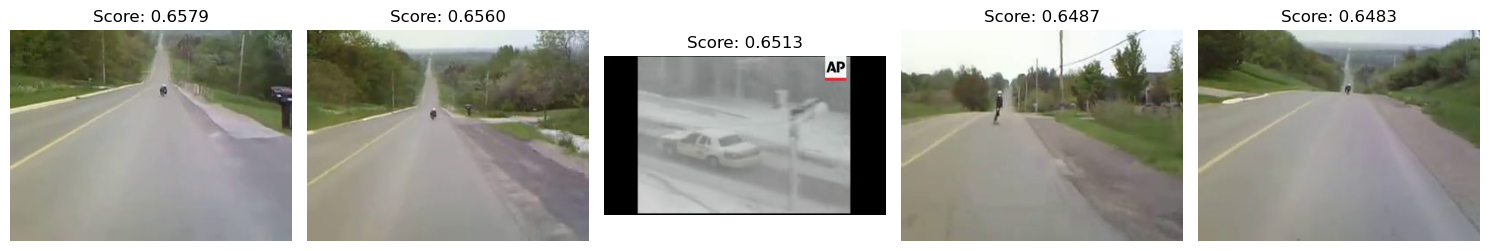


EXAMPLE 2: Image-to-Image Search
Query image: extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
Using device: cpu
Generating embedding for query image: 'extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg'
Searching for top 5 images similar to the provided image...
Found 5 results:
1. Score: 1.0000 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
2. Score: 0.8529 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_96_10_frame_0048.jpg
3. Score: 0.8437 | Video: v_9hR1MHvXGv8 | Frame: v_9hR1MHvXGv8_ts_0_00_frame_0000.jpg
4. Score: 0.8420 | Video: v_Eilil6FZhK8 | Frame: v_Eilil6FZhK8_ts_0_00_frame_0000.jpg
5. Score: 0.8401 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_2_00_frame_0001.jpg


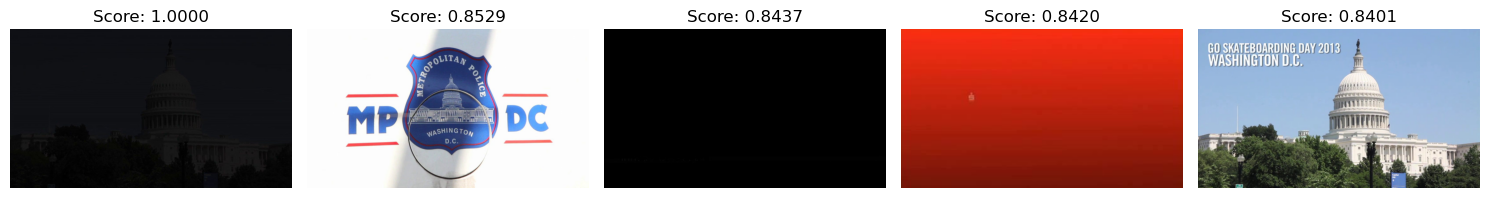


EXAMPLE 3: Multiple Images Combined (images+images)
Query images with weights:
- extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg (weight: 0.7)
- extracted_frames\v_1LdbczjQPII\v_1LdbczjQPII_ts_108_11_frame_0054.jpg (weight: 0.3)
Using device: cpu
Generating embedding for image: extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
Generating embedding for image: extracted_frames\v_1LdbczjQPII\v_1LdbczjQPII_ts_108_11_frame_0054.jpg
Searching with combined embedding from 2 images...
Found 5 results:
1. Score: 0.9768 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
2. Score: 0.8743 | Video: v_1LdbczjQPII | Frame: v_1LdbczjQPII_ts_58_06_frame_0029.jpg
3. Score: 0.8696 | Video: v_1LdbczjQPII | Frame: v_1LdbczjQPII_ts_56_06_frame_0028.jpg
4. Score: 0.8667 | Video: v_9hR1MHvXGv8 | Frame: v_9hR1MHvXGv8_ts_0_00_frame_0000.jpg
5. Score: 0.8646 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_50_05_frame_0025.jpg


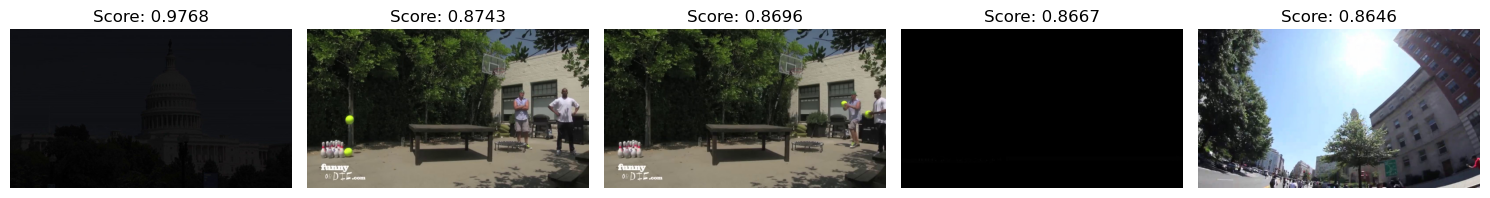


EXAMPLE 4: Text and Image Combined (text+image)
Query:
- Text: 'person walking' (weight: 0.6)
- Image: extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg (weight: 0.4)
Using device: cpu
Generating embedding for text: 'person walking'
Generating embedding for image: extracted_frames\v_06ofnvq2Hjs\v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
Searching with combined text (0.6) and image (0.4) embedding...
Found 5 results:
1. Score: 0.8293 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_0_00_frame_0000.jpg
2. Score: 0.7722 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_50_05_frame_0025.jpg
3. Score: 0.7679 | Video: v_9hR1MHvXGv8 | Frame: v_9hR1MHvXGv8_ts_0_00_frame_0000.jpg
4. Score: 0.7636 | Video: v_06ofnvq2Hjs | Frame: v_06ofnvq2Hjs_ts_202_20_frame_0101.jpg
5. Score: 0.7636 | Video: v_1LdbczjQPII | Frame: v_1LdbczjQPII_ts_158_16_frame_0079.jpg


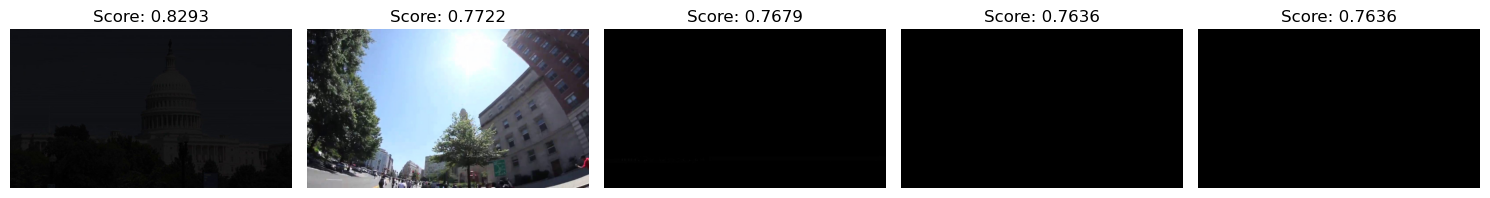


EXAMPLE 5: Multiple Text Queries Combined (text+text)
Query texts with weights:
- 'car' (weight: 0.4)
- 'driving on highway' (weight: 0.6)
Using device: cpu
Generating embedding for text query 1: 'car'
Generating embedding for text query 2: 'driving on highway'
Searching with combined embedding from 2 text queries...
Found 5 results:
1. Score: 0.6463 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_54_00_frame_0027.jpg
2. Score: 0.6452 | Video: v_9DVsv84awMg | Frame: v_9DVsv84awMg_ts_10_00_frame_0005.jpg
3. Score: 0.6437 | Video: v_Gms3Yt6RrV4 | Frame: v_Gms3Yt6RrV4_ts_50_00_frame_0025.jpg
4. Score: 0.6434 | Video: v_9DVsv84awMg | Frame: v_9DVsv84awMg_ts_8_00_frame_0004.jpg
5. Score: 0.6430 | Video: v_9DVsv84awMg | Frame: v_9DVsv84awMg_ts_120_00_frame_0060.jpg


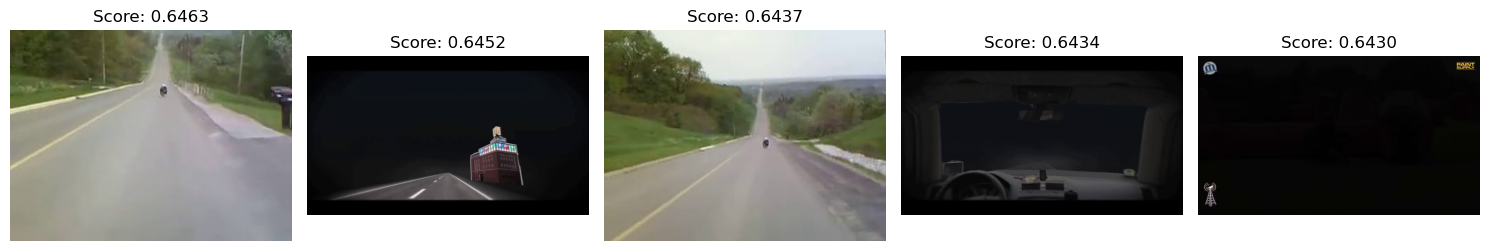

In [10]:
import os
import json
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import urllib3
from opensearchpy import OpenSearch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import time

# Suppress SSL warnings for self-signed certificates
urllib3.disable_warnings()

# --- Configuration ---
# OpenSearch settings
OPENSEARCH_HOST = "localhost"
OPENSEARCH_PORT = 9200
OPENSEARCH_USER = "admin" 
OPENSEARCH_PASSWORD = "MyStr0ng@Pass"
USE_SSL = True
VERIFY_CERTS = False

# Index names
IMAGE_INDEX_NAME = "admin_clip_image_embeddings"
TEXT_INDEX_NAME = "admin_clip_text_embeddings"

# CLIP model settings
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"

# Image frames directory
FRAMES_BASE_DIR = "extracted_frames"  

# Number of results to return
TOP_K = 5

# --- Setup ---
def setup_opensearch_client():
    """Connect to OpenSearch."""
    client = OpenSearch(
        hosts=[{"host": OPENSEARCH_HOST, "port": OPENSEARCH_PORT}],
        http_auth=(OPENSEARCH_USER, OPENSEARCH_PASSWORD),
        use_ssl=USE_SSL,
        verify_certs=VERIFY_CERTS,
        ssl_show_warn=False
    )
    # Check connection
    health = client.cluster.health()
    print(f"Connected to OpenSearch cluster: {health['cluster_name']}")
    print(f"Cluster health: {health['status']}")
    return client

def setup_clip_model():
    """Load CLIP model and processor."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
    model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
    model.eval()
    
    return processor, model, device

# --- Helper Functions ---
def get_text_embedding(text, processor, model, device):
    """Generate CLIP embedding for a text query."""
    inputs = processor(text=text, images=None, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features_normalized = text_features / text_features.norm(dim=-1, keepdim=True)
    
    return text_features_normalized.cpu().numpy().squeeze().tolist()

def get_image_embedding(image_path, processor, model, device):
    """Generate CLIP embedding for an image."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=None, images=image, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features_normalized = image_features / image_features.norm(dim=-1, keepdim=True)
        
    return image_features_normalized.cpu().numpy().squeeze().tolist()

def find_frame_file_path(frame_filename, video_id=None):
    """Find the full path to a frame file based on its filename and optionally video_id."""
    frames_base_path = Path(FRAMES_BASE_DIR)
    
    if video_id:
        # If we know the video ID, search directly in that subfolder
        video_dir = frames_base_path / video_id
        frame_path = video_dir / frame_filename
        if frame_path.exists():
            return str(frame_path)
    
    # If frame not found or no video_id, search in all video subfolders
    for video_dir in frames_base_path.iterdir():
        if video_dir.is_dir():
            frame_path = video_dir / frame_filename
            if frame_path.exists():
                return str(frame_path)
    
    return None

def combine_embeddings(embeddings, weights=None):
    """
    Combine multiple embedding vectors with optional weights.
    
    Args:
        embeddings: List of embedding vectors
        weights: List of weights for each embedding (default: equal weights)
    
    Returns:
        Combined normalized embedding vector
    """
    if not embeddings:
        return None
    
    # If weights not provided, use equal weights
    if weights is None:
        weights = [1.0 / len(embeddings)] * len(embeddings)
    else:
        # Normalize weights to sum to 1
        total = sum(weights)
        weights = [w / total for w in weights]
    
    # Convert to numpy arrays
    embeddings = [np.array(e) for e in embeddings]
    
    # Combine embeddings with weights
    combined = np.zeros_like(embeddings[0])
    for emb, weight in zip(embeddings, weights):
        combined += emb * weight
    
    # Normalize the combined embedding
    norm = np.linalg.norm(combined)
    if norm > 0:
        combined = combined / norm
    
    return combined.tolist()

def display_results(results, show_images=True):
    """Display search results with optional image rendering."""
    print(f"Found {len(results)} results:")
    
    for i, result in enumerate(results):
        print(f"{i+1}. Score: {result['score']:.4f} | Video: {result['video_id']} | Frame: {result['frame_filename']}")

    if show_images:
        # Display images if available
        valid_paths = [r['frame_path'] for r in results if r['frame_path']]
        if valid_paths:
            n = len(valid_paths)
            fig, axes = plt.subplots(1, n, figsize=(15, 10))
            
            # Handle case with single image
            if n == 1:
                axes = [axes]
            
            for i, (ax, img_path) in enumerate(zip(axes, valid_paths)):
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"Score: {results[i]['score']:.4f}", wrap=True)
            
            plt.tight_layout()
            plt.show()
        else:
            print("No valid image paths found in results.")

# --- Search Functions ---
def text_to_image_search(client, text_query, top_k=5):
    """Search for images matching a text description."""
    processor, model, device = setup_clip_model()
    
    print(f"Generating embedding for text query: '{text_query}'")
    query_embedding = get_text_embedding(text_query, processor, model, device)
    
    print(f"Searching for top {top_k} images matching: '{text_query}'")
    query_body = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": query_embedding,
                    "k": top_k
                }
            }
        }
    }
    
    response = client.search(
        body=query_body,
        index=IMAGE_INDEX_NAME
    )
    
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        source = hit['_source']
        video_id = source.get('video_id', '')
        frame_filename = source.get('frame_filename', '')
        timestamp = source.get('timestamp_str', '')
        
        # Find the actual file path
        frame_path = find_frame_file_path(frame_filename, video_id)
        
        results.append({
            'score': score,
            'video_id': video_id,
            'frame_filename': frame_filename,
            'timestamp': timestamp,
            'frame_path': frame_path
        })
    
    return results

def image_to_image_search(client, image_path, top_k=5):
    """Search for images similar to the given image."""
    processor, model, device = setup_clip_model()
    
    print(f"Generating embedding for query image: '{image_path}'")
    query_embedding = get_image_embedding(image_path, processor, model, device)
    
    print(f"Searching for top {top_k} images similar to the provided image...")
    query_body = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": query_embedding,
                    "k": top_k
                }
            }
        }
    }
    
    response = client.search(
        body=query_body,
        index=IMAGE_INDEX_NAME
    )
    
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        source = hit['_source']
        video_id = source.get('video_id', '')
        frame_filename = source.get('frame_filename', '')
        timestamp = source.get('timestamp_str', '')
        
        # Find the actual file path
        frame_path = find_frame_file_path(frame_filename, video_id)
        
        results.append({
            'score': score,
            'video_id': video_id,
            'frame_filename': frame_filename,
            'timestamp': timestamp,
            'frame_path': frame_path
        })
    
    return results

def multi_image_search(client, image_paths, weights=None, top_k=5):
    """Search with multiple images combined (images+images)."""
    processor, model, device = setup_clip_model()
    
    # Generate embeddings for all images
    embeddings = []
    for path in image_paths:
        if os.path.exists(path):
            print(f"Generating embedding for image: {path}")
            emb = get_image_embedding(path, processor, model, device)
            embeddings.append(emb)
        else:
            print(f"Warning: Image file not found: {path}")
    
    # Combine embeddings
    combined_embedding = combine_embeddings(embeddings, weights)
    
    print(f"Searching with combined embedding from {len(embeddings)} images...")
    query_body = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": combined_embedding,
                    "k": top_k
                }
            }
        }
    }
    
    response = client.search(
        body=query_body,
        index=IMAGE_INDEX_NAME
    )
    
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        source = hit['_source']
        video_id = source.get('video_id', '')
        frame_filename = source.get('frame_filename', '')
        timestamp = source.get('timestamp_str', '')
        
        # Find the actual file path
        frame_path = find_frame_file_path(frame_filename, video_id)
        
        results.append({
            'score': score,
            'video_id': video_id,
            'frame_filename': frame_filename,
            'timestamp': timestamp,
            'frame_path': frame_path
        })
    
    return results

def text_and_image_search(client, text_query, image_path, text_weight=0.5, top_k=5):
    """Search with text and image combined (text+image)."""
    processor, model, device = setup_clip_model()
    
    # Generate text embedding
    print(f"Generating embedding for text: '{text_query}'")
    text_embedding = get_text_embedding(text_query, processor, model, device)
    
    # Generate image embedding
    print(f"Generating embedding for image: {image_path}")
    image_embedding = get_image_embedding(image_path, processor, model, device)
    
    # Combine embeddings with weights
    weights = [text_weight, 1.0 - text_weight]
    combined_embedding = combine_embeddings([text_embedding, image_embedding], weights)
    
    print(f"Searching with combined text ({text_weight:.1f}) and image ({1-text_weight:.1f}) embedding...")
    query_body = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": combined_embedding,
                    "k": top_k
                }
            }
        }
    }
    
    response = client.search(
        body=query_body,
        index=IMAGE_INDEX_NAME
    )
    
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        source = hit['_source']
        video_id = source.get('video_id', '')
        frame_filename = source.get('frame_filename', '')
        timestamp = source.get('timestamp_str', '')
        
        # Find the actual file path
        frame_path = find_frame_file_path(frame_filename, video_id)
        
        results.append({
            'score': score,
            'video_id': video_id,
            'frame_filename': frame_filename,
            'timestamp': timestamp,
            'frame_path': frame_path
        })
    
    return results

def multi_text_search(client, text_queries, weights=None, top_k=5):
    """Search with multiple text queries combined (text+text)."""
    processor, model, device = setup_clip_model()
    
    # Generate embeddings for all text queries
    embeddings = []
    for i, query in enumerate(text_queries):
        print(f"Generating embedding for text query {i+1}: '{query}'")
        emb = get_text_embedding(query, processor, model, device)
        embeddings.append(emb)
    
    # Combine embeddings
    combined_embedding = combine_embeddings(embeddings, weights)
    
    print(f"Searching with combined embedding from {len(embeddings)} text queries...")
    query_body = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": combined_embedding,
                    "k": top_k
                }
            }
        }
    }
    
    response = client.search(
        body=query_body,
        index=IMAGE_INDEX_NAME
    )
    
    results = []
    for hit in response['hits']['hits']:
        score = hit['_score']
        source = hit['_source']
        video_id = source.get('video_id', '')
        frame_filename = source.get('frame_filename', '')
        timestamp = source.get('timestamp_str', '')
        
        # Find the actual file path
        frame_path = find_frame_file_path(frame_filename, video_id)
        
        results.append({
            'score': score,
            'video_id': video_id,
            'frame_filename': frame_filename,
            'timestamp': timestamp,
            'frame_path': frame_path
        })
    
    return results

# --- Run Example Queries with Hardcoded Values ---
def run_examples():
    client = setup_opensearch_client()
    
    # Get a sample frame path for image-based queries
    first_video_id = None
    first_frame_path = None
    second_frame_path = None
    
    frames_base_path = Path(FRAMES_BASE_DIR)
    for video_dir in frames_base_path.iterdir():
        if video_dir.is_dir():
            frame_files = list(video_dir.glob("*.jpg"))
            if frame_files:
                if not first_frame_path:
                    first_video_id = video_dir.name
                    first_frame_path = str(frame_files[0])
                elif not second_frame_path:
                    second_frame_path = str(frame_files[min(5, len(frame_files)-1)])  # Get a different frame
                    break
    
    if not first_frame_path:
        print("Error: Could not find any frame files for examples.")
        return
    
    print(f"\nUsing sample frames:\n- {first_frame_path}\n- {second_frame_path}")
    
    # Example 1: Basic Text-to-Image Search
    print("\n" + "="*80)
    print("EXAMPLE 1: Text-to-Image Search")
    print("="*80)
    text_query = "a car driving on a road"
    print(f"Query: '{text_query}'")
    
    results = text_to_image_search(client, text_query, top_k=TOP_K)
    display_results(results)
    
    # Example 2: Basic Image-to-Image Search
    print("\n" + "="*80)
    print("EXAMPLE 2: Image-to-Image Search")
    print("="*80)
    print(f"Query image: {first_frame_path}")
    
    results = image_to_image_search(client, first_frame_path, top_k=TOP_K)
    display_results(results)
    
    # Example 3: Multiple Images Combined (images+images)
    print("\n" + "="*80)
    print("EXAMPLE 3: Multiple Images Combined (images+images)")
    print("="*80)
    image_paths = [first_frame_path, second_frame_path]
    weights = [0.7, 0.3]  # More weight to the first image
    
    print(f"Query images with weights:")
    for img, w in zip(image_paths, weights):
        print(f"- {img} (weight: {w})")
    
    results = multi_image_search(client, image_paths, weights, top_k=TOP_K)
    display_results(results)
    
    # Example 4: Text and Image Combined (text+image)
    print("\n" + "="*80)
    print("EXAMPLE 4: Text and Image Combined (text+image)")
    print("="*80)
    text_query = "person walking"
    text_weight = 0.6  # 60% text, 40% image
    
    print(f"Query:")
    print(f"- Text: '{text_query}' (weight: {text_weight})")
    print(f"- Image: {first_frame_path} (weight: {1-text_weight})")
    
    results = text_and_image_search(client, text_query, first_frame_path, text_weight, top_k=TOP_K)
    display_results(results)
    
    # Example 5: Multiple Text Queries Combined (text+text)
    print("\n" + "="*80)
    print("EXAMPLE 5: Multiple Text Queries Combined (text+text)")
    print("="*80)
    text_queries = ["car", "driving on highway"]
    weights = [0.4, 0.6]  # More weight to the second text
    
    print(f"Query texts with weights:")
    for txt, w in zip(text_queries, weights):
        print(f"- '{txt}' (weight: {w})")
    
    results = multi_text_search(client, text_queries, weights, top_k=TOP_K)
    display_results(results)

if __name__ == "__main__":
    print("Running CLIP Retrieval Examples with Hardcoded Queries")
    print("Date and Time: 2025-05-16 01:08:38")
    print("User: NoxGhost")
    print("="*80)
    
    run_examples()